# Assignment 2
## Stochastic and Spatial Models
---
Peterson, Victoria J  
*ID: 15476758* 

Beumer, Wessel T L
*ID: 12640662*

University of Amsterdam  
*Introduction to Computational Science, Block 1, 2024*  

Due: 27 October 2024

---

In [1]:
import numpy as np
from scipy.integrate import odeint 
import networkx as nx
import ndlib.models.epidemics as ep
import dataclasses
import matplotlib.pyplot as plt

In [2]:
@dataclasses.dataclass
class Results:
    S_List: list[int]
    I_List: list[int]
    R_List: list[int]
    time: list[float]

In [3]:
class Event:
    dX = 0.0
    dY = 0.0
    dZ = 0.0
    rate = 0.0


class Transmission(Event):
    def __init__(self, beta, X, Y, Z, N):
        self.dX = -1
        self.dY = 1
        self.dZ = 0
        self.rate = beta*X*Y/N

class Births(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 1
        self.dY = 0
        self.dZ = 0
        self.rate = mu*N

class DeathsX(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = -1
        self.dY = 0.0
        self.dZ = 0.0
        self.rate = mu*X

class DeathsY(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 0.0
        self.rate = mu*Y

class DeathsZ(Event):
    def __init__(self, mu, X, Y, Z, N):
        self.dX = 0.0
        self.dY = 0.0
        self.dZ = -1
        self.rate = mu*Z

class Recovery(Event):
    def __init__(self, gamma, X, Y, Z, N):
        self.dX = 0.0
        self.dY = -1
        self.dZ = 1
        self.rate = gamma*Y

In [4]:
class SIRModelGillespies:
    def __init__ (self, X, Y, Z, N, beta, gamma, mu):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.results = Results([], [], [], [])

    def calcEvents(self):
        events = []
        events.append(Transmission(self.beta, self.X, self.Y, self.Z, self.N))
        events.append(Births(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsX(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsY(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(DeathsZ(self.mu, self.X, self.Y, self.Z, self.N))
        events.append(Recovery(self.gamma, self.X, self.Y, self.Z, self.N))
        return events

    def gillespiesAlgorithm(self):
        events = self.calcEvents()
        rateTotal = sum([i.rate for i in events])

        deltaT = -1/rateTotal * np.log(np.random.rand())

        probabilities = np.random.rand() * rateTotal

        upperRate = 0

        for i in events:
            lowerRate = upperRate
            upperRate += i.rate

            if lowerRate < probabilities <= upperRate:
                return i, deltaT


    def gillespiesSimulation(self, finalTime):
        time = 0

        while time < finalTime:
            event, deltaT = self.gillespiesAlgorithm()
            time += deltaT

            self.X += event.dX
            self.Y += event.dY
            self.Z += event.dZ

            self.results.S_List.append(self.X)
            self.results.I_List.append(self.Y)
            self.results.R_List.append(self.Z)
            self.results.time.append(time)


In [9]:
class SIRModelDeterministic:
    def __init__ (self, X, Y, Z, N, beta, gamma, mu, timeInterval, timeFinal):
        
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.timeInterval = timeInterval
        self.timeFinal = timeFinal
        self.results = Results([], [], [], [])

    def SIRModel(self):
        timeSpan = np.linspace(0, self.timeInterval, self.timeFinal)

        S = np.zeros(self.timeFinal//self.timeInterval)
        I = np.zeros(self.timeFinal//self.timeInterval)
        R = np.zeros(self.timeFinal//self.timeInterval)

        S[0], I[0], R[0] = self.X, self.Y, self.Z

        for t in range(1, len(timeSpan)):
            dSdt = self.mu * (self.N - S[t-1]) - self.beta * S[t-1] * I[t-1] / self.N
            dIdt = self.beta * S[t-1] * I[t-1] / self.N - self.gamma * I[t-1] - self.mu * I[t-1]
            dRdt = self.gamma * I[t-1] - self.mu * R[t-1]

            S[t] = S[t-1] + self.timeInterval * dSdt
            I[t] = I[t-1] + self.timeInterval * dIdt
            R[t] = R[t-1] + self.timeInterval * dRdt

        self.results.S_List = S
        self.results.I_List = I
        self.results.R_List = R
        self.results.time = timeSpan

            



In [10]:
# Initial Values
X0 = 999  
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
beta = 0.5
gamma = 0.1
mu = 0.01

time = 1000


model = SIRModelGillespies(X0, Y0, Z0, N, beta, gamma, mu)

model.gillespiesSimulation(time)

#for i in range(len(model.results.time)):
#    print(model.results.time[i], model.results.S_List[i], model.results.I_List[i], model.results.R_List[i])


deterministicModel = SIRModelDeterministic(X0, Y0, Z0, N, beta, gamma, mu, 1, time)

deterministicModel.SIRModel()

for i in range(len(deterministicModel.results.time)):
    print(deterministicModel.results.time[i], deterministicModel.results.S_List[i], deterministicModel.results.I_List[i], deterministicModel.results.R_List[i])

0.0 999.0 1.0 0.0
0.001001001001001001 998.5105 1.3895 0.1
0.002002002002002002 997.8316798301249 1.930370169875 0.23795
0.003003003003003003 996.8902707771736 2.6811217058389176 0.4286075169875
0.004004004004004004 995.5849759977417 3.7225903898567947 0.6924336124015167
0.005005005005005005 993.7760487057968 5.166182978940048 1.057768315263181
0.006006006006006006 991.2712737648877 7.164917305107735 1.563808930004554
0.007007007007007007 987.8073726755117 9.927964753272999 2.2646625712152817
0.008008008008008008 983.0258405592838 13.739347019885813 3.234812420830429
0.009009009009009009 976.4425155772115 18.98108542417784 4.576398998610706
0.01001001001001001 967.4111210214543 26.160135427503356 6.428743551042383
0.011011011011011011 955.0832068412427 35.93632350047503 8.980469658282296
0.012012012012012012 938.3712852273713 49.14441746088177 12.484297311746975
0.013013013013013013 915.9297172878386 66.79638662744382 17.273896084717684
0.014014014014014014 886.1800223551983 90.0391818

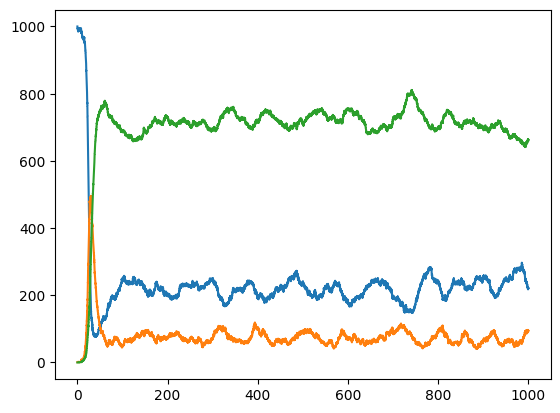

In [11]:
plt.figure()
plt.plot(model.results.time, model.results.S_List, label='S')
plt.plot(model.results.time, model.results.I_List, label='I')
plt.plot(model.results.time, model.results.R_List, label='R')

plt.show()

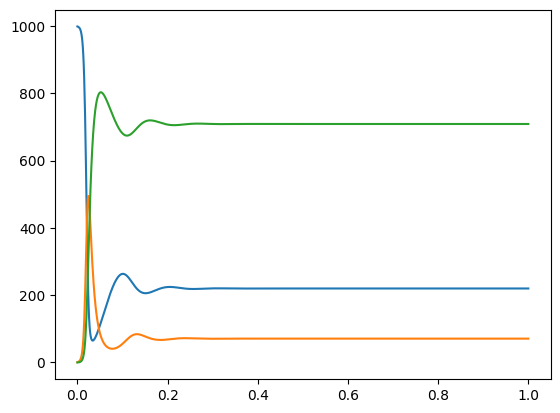

In [12]:
plt.figure()
plt.plot(deterministicModel.results.time, deterministicModel.results.S_List, label='S')
plt.plot(deterministicModel.results.time, deterministicModel.results.I_List, label='I')
plt.plot(deterministicModel.results.time, deterministicModel.results.R_List, label='R')
plt.show()